#  Motivation
************************************************************************************

In the era of ‘big data’, vast amounts of data are being collected and curated in the form of arrays across the social, physical, engineering, biological, and ecological sciences.  Analysis of the data relies on a variety of matrix decomposition methods which seek to exploit low-rank features exhibited by the high-dimensional data.  Indeed, matrix decompositions are often the workhorse algorithms for scientific computing applications in the areas of applied mathematics, statistical  computing,  and  machine  learning.   Despite  our  ever-increasing  computational power, the emergence of large-scale datasets has severely challenged our ability to analyze data  using  traditional  matrix  algorithms.   Moreover,  the  growth  of  data  collection  is  far
outstripping computational performance gains.  The computationally expensive singular value
decomposition  (SVD)  is  the  most  ubiquitous  method  for  dimensionality  reduction,  data
processing and compression.  The concept of randomness has recently been demonstrated as
an effective strategy to easing the computational demands of low-rank approximations from
matrix decompositions such as the SVD, thus allowing for a scalable architecture for modern
‘big data’ applications. Here is the computational performance for a rank $500$ approximation using 

<img src="img/rand_only_c48xlarge.png" alt="Drawing" style="width: 600px;"/>


Randomness as a computational strategy is interesting if we an make the following assumption:  the data matrix to be approximated has low-rank structure, i.e., the rank is smaller than the ambient
dimension of the measurement space. Fortunately, this assumption is valid for most machine learning applications.

#  Tutorial Outcomes
************************************************************************************

* Quick refresher about the singular value decomposition. 

* Get a feeling for randomized numerical linear algebra (RandNLA).

* You learn how to use the randomized svd function from the ristretto package.

* You will use the randomized SVD for speeding-up a robust PCA algorithm which we use to remove outliers from a dataset. 

* Then, you will see how the randomized svd can be used to scale applications in light of limited fast memory.

* (Optional) If you like, you can try to use the Randomized PCA and Randomized SPACA to extract features from the  EMNIST dataset, which you can then use to train a predictive model, for instance, using Random Forest.

* (Optional) If you like, you can try to implement the randomized SVD yourself at the end of this tutorial.

#  Brief Review of the Singular Value Decomposition (SVD)
************************************************************************************
The SVD provides a numerically stable matrix decomposition that can be used to obtain
low-rank approximations, to compute the pseudo-inverses of non-square matrices, and to find
the least-squares and minimum norm solutions of a linear model.  Further, the SVD is the
workhorse algorithm behind many machine learning concepts, for instance, matrix completion,
sparse coding,  dictionary learning,  PCA and robust PCA. 

Suppose we are given a $m\times n$ matrix $\mathbf{A}$, where $m$ denotes the number of rows and $n$ the number of columns. Without loss of generality we assume that $n\leq m$. The singular value decomposition admits the following factorization 

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{U} & \mathbf{\Sigma}  & \mathbf{V}^\top\\
	m\times n &   &  m\times n & n\times n  & n\times n
	\end{array} 
\end{equation}

$\mathbf{U}$ denotes the left singular vectors, $\mathbf{V}$ are the right singular, and $\mathbf{\Sigma}$ contains the non-negative singular values vectors. In many applications the numeric rank $r$ of a matrix is much smaller than the ambient dimensions of the input matrix 


<img src="img/svd.png" alt="Drawing" style="width: 600px;"/>

This is, for instance, the case if some of the information in the data are redundant.
In such situations we are interested in computing as few components as possible. This leads to the concept of low-rank factorizations, where we try to represent the original data matrix by using as few singular vectors as possible. Often, we define a desired target-rank $k$ to yield the following factorization

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{U} & \mathbf{\Sigma}  & \mathbf{V}^\top\\
	m\times n &   &  m\times k & k\times k  & k\times n
	\end{array} 
\end{equation}

Choosing  an  optimal  target  rank $k$ is  highly  dependent  on  the  task.   One  can  either  be interested in a highly accurate reconstruction of the original data, or in a very low dimensional representation of dominant features in the data.  In the former case $k$ should be chosen close to the effective rank, while in the latter case $k$ might be chosen to be much smaller.

##  Randomized Singular Value Decomposition (RSVD)
************************************************************************************
Randomized algorithms have been recently popularized, in large part due to their ‘surprising’
reliability and computational efficiency to obtain an approximate rank-$k
$ factorization. When the dimensions of $\mathbf{A}$ are large, randomized methods are more efficient than truncating the full SVD. We omit technical details here, but refer the interested reader to this neat blog post by Andrew Tulloch (Facebook Reserach):

* https://research.fb.com/fast-randomized-svd/

For a more technical treatment we refer to the following references:

* Randomized algorithms for matrices and data (https://arxiv.org/abs/1104.5557)
* Finding structure with randomness (https://arxiv.org/abs/0909.4061)
* Randomized Matrix Decompositions using R (https://arxiv.org/pdf/1608.02148.pdf)

# The Ristretto Package
You can find randomized methods for linear algebra in scikit learn to compute the SVD and PCA. Here, we use the ristretto package, which provides a collection of randomized algorithms for a range of applications. This package is still under development, and many more features are to come soon. For the moment just have a look (and don't forget to give a star :D):

* https://github.com/erichson/ristretto/
* https://ristretto.readthedocs.io/en/latest/


You don't have to worry about it now, but installation is easy:

``` pip install git+https://github.com/erichson/ristretto/```

### Contact

Hints, suggestions and feedback are warmly welcome, just drop me ( erichson@berkeley.edu ) or Joe (joseph.edward.knox@gmail.com) an email, or use the wish list on git ( https://github.com/erichson/ristretto/projects ). 

# Let's Get Started

Here are the libraries we are going to use in this tutorial:

In [1]:
import numpy as np
import scipy as sci
from scipy import ndimage 
from tqdm import trange
import h5py
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white")
from misc import *

In [2]:
from numpy.linalg import svd
from ristretto.svd import compute_rsvd as rsvd

We start this tutorial by reading in an image:

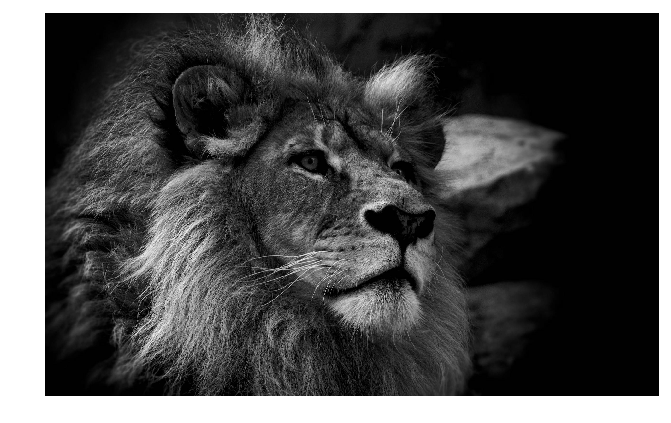

In [3]:
# Read in image
A = plt.imread('./data/lion.jpg')

# Convert to a grayscale image
A = np.dot(A[...,:3], [0.299, 0.587, 0.114])

# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow(A, cmap = 'gray')
plt.axis('off')
plt.show()

## Computing the truncated SVD using Numpy

For convenience, we define a new function ```tsvd()``` to compute the truncated SVD using Numpy's svd function. In the following we can then pass the desired target-rank as an argument and the function returns the truncated singular vectors and values. 

In [4]:
from numpy.linalg import svd

In [5]:
def tsvd(A, rank):
    U, s, Vt = np.linalg.svd(A , full_matrices=False)
    return U[:,0:rank], s[0:rank], Vt[0:rank,:]

Now, we can compute the truncated SVD to compress the above image. For instance, we can decide to use the target-rank 200:

In [6]:
%%time
U, S, Vt = tsvd(A, rank=200)

CPU times: user 7.8 s, sys: 162 ms, total: 7.96 s
Wall time: 1.33 s


We can reconstruct the original image as:

In [7]:
A_appox = (U*S).dot(Vt)

The relative error is:

In [8]:
print('Relative reconstruction error:', np.linalg.norm(A-A_appox) / np.linalg.norm(A))

Relative reconstruction error: 0.118983274637


Can we get a nearly as good result, but faster? Let's try the randomized SVD.

In [9]:
from ristretto.svd import compute_rsvd as rsvd

In [10]:
%%time
U, S, Vt = rsvd(A, rank=200, oversample=20, n_subspace=2)

CPU times: user 1.72 s, sys: 27.3 ms, total: 1.75 s
Wall time: 292 ms


That was quite a bit fast, but how good did we do in terms of the approximation quality?

In [11]:
A_rand_appox = (U*S).dot(Vt)
print('Relative reconstruction error:', np.linalg.norm(A-A_rand_appox) / np.linalg.norm(A))

Relative reconstruction error: 0.120958424928


Not good enough? Well, go back and try to change the oversample parameter value to 50. If, that is still not good enough for you, then you can increase the number of subspace iterations, say, to 6. You will see that computing the randomized SVD requires some more computational resources, now. In summary, you can control the trade-off between speed and accuracy via the amount of oversampling and the number of subspace iterations. In most machine learning applications the default values (oversample=20, n_subspace=2) are good enough, in our experience. 

Now, let's do a visual comparison between the deterministic and randomized low-rank approximation:

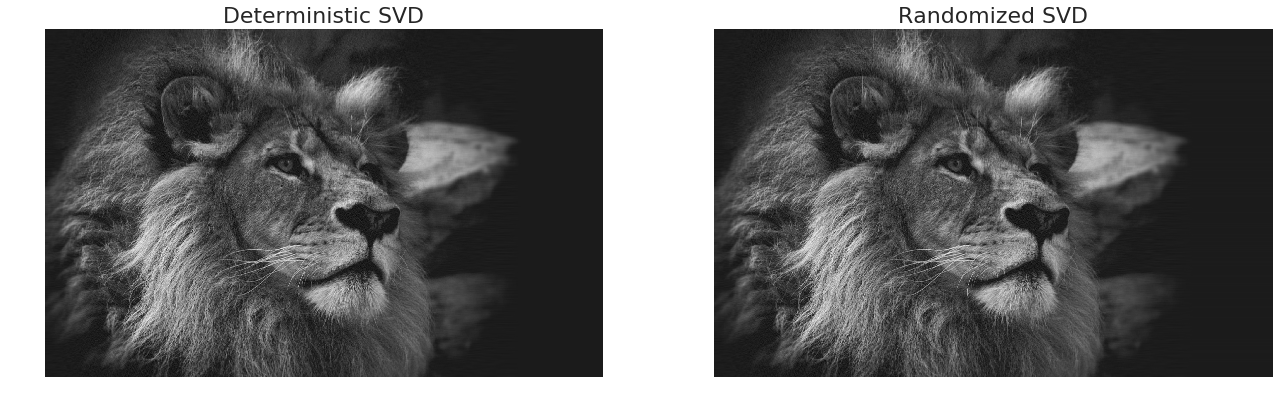

In [12]:
# Display image
f = plt.figure(figsize=(22,9))
f.add_subplot(121)
plt.imshow(A_appox, cmap = 'gray')
plt.axis('off')
plt.title('Deterministic SVD', fontsize=22)

f.add_subplot(122)
plt.imshow(A_rand_appox, cmap = 'gray')
plt.axis('off')
plt.title('Randomized SVD', fontsize=22)
plt.show()

## Corrupted Data

Let's add some salt and pepper noise to our image:

In [13]:
Anoisy = noisy("s&p", A, amount=0.05)

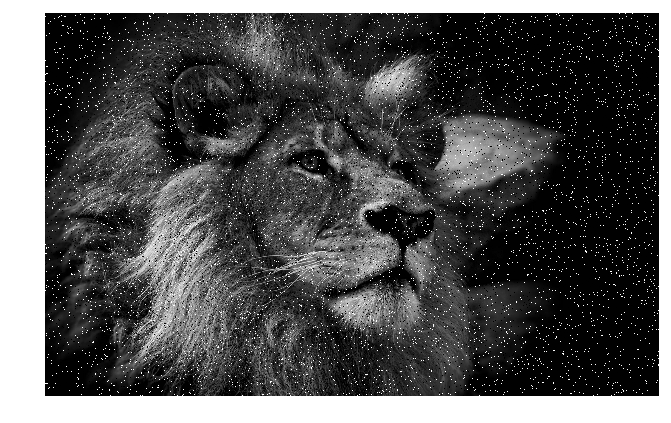

In [14]:
# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow(Anoisy, cmap = 'gray')
plt.axis('off')
plt.show()

Now, computing just the SVD, both the determenistic and randomized algorithms, provide a grainy approximation:

In [15]:
U, S, Vt = tsvd(Anoisy, rank=200)
print('Relative reconstruction error:', np.linalg.norm(A-(U*S).dot(Vt)) / np.linalg.norm(A) )

Relative reconstruction error: 0.339981503708


In [16]:
U, S, Vt = rsvd(Anoisy, rank=200)
print('Relative reconstruction error:',np.linalg.norm(A-(U*S).dot(Vt)) / np.linalg.norm(A) )

Relative reconstruction error: 0.338432238757


Surprisingly, the randomized SVD does slightly better. This is what we call an intrinsic regularization effect.

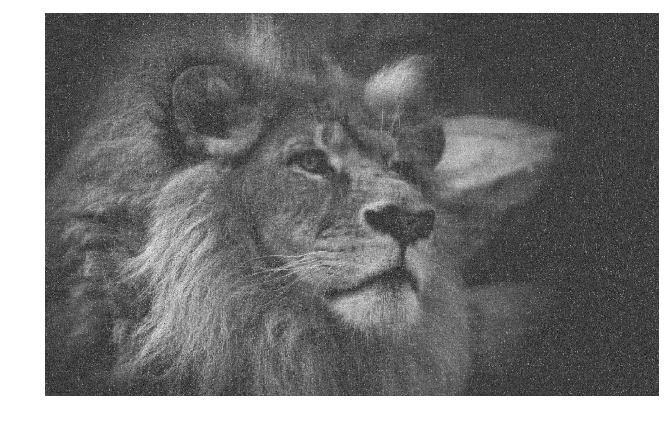

In [17]:
# Display image
fig = plt.figure(figsize=(11, 9))
plt.imshow((U*S).dot(Vt), cmap = 'gray')
plt.axis('off')
plt.show()

# Robust Principal Component Analysis

In many data science applications we need robust methods which can more effectively account for corrupt or missing data.  Indeed, outlier rejection is critical in many applications as data is rarely free of corrupt elements.
Robustification methods decompose data matrices as follows:

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{A}  & \approx & \mathbf{L} & \mathbf{E}\\
	m\times n &   &  m\times n & m\times n 
	\end{array} 
\end{equation}
where $\mathbf{L}$ denotes a low-rank matrix and $\mathbf{E}$ a sparse matrix capturing the corrupted entries (outliers) of the input data matrix.

This  form of additive decomposition (i.e., the  decomposition  of  a  matrix  into  its  sparse  and  low-rank  components) is also denoted as robust principal component analysis (RPCA). Its remarkable ability to separate high-dimensional matrices into low-rank and sparse component makes RPCA an invaluable tool for data science. However, the biggest challenge for robust PCA is computational efficiency, especially given the iterative
nature of the optimization required.

Computing the robust PCA is based on an iterative scheme, requiring to computing the SVD in each iteration. The computational costs can be drastic using the deterministic SVD. In the following we have compiled some toy code to compute the robust PCA. Note, that the following code is just intended to demonstrate the idea. More concreatly, we use a proximal gradient algorithm to solve the following minimixation problem:

\begin{equation}
	\text{min}  \, \|\mathbf{A} -  \mathbf{L} - \mathbf{E}\|_F^2 \, + \, \alpha \|\mathbf{E}\|_1
\end{equation}


In [18]:
def robust_pca(A, rank, alpha, max_iter):
    
    # Init
    E = np.zeros_like(A) 
    alpha *= np.linalg.norm(A, 2)**2 
    
    for i in trange(max_iter):
        
        # i) Compute the SVD
        U, s, Vt = tsvd(A-E, rank=rank)
        
        # ii) Compute prox gradient step
        grad = E - (A - (U*s).dot(Vt)) # compute gradient
        E = E - 0.1 * grad
        
        # iii) Soft threshold (l1 regularization)
        E = np.clip(abs(E) - alpha * 0.1, 0, None) * np.sign(E)    
        
        
    return (U*s).dot(Vt), E

Okay, let's run the algorithm using the truncated SVD for a maximum of 20 iterations:

In [19]:
Are, E = robust_pca(Anoisy, rank=200, alpha=1e-9, max_iter=20)
print('Relative reconstruction error:', np.linalg.norm(A-Are) / np.linalg.norm(A))

100%|██████████| 20/20 [00:32<00:00,  1.59s/it]

Relative reconstruction error: 0.21941690589


This takes quite some time!!! 

* First, can you change the code and use the ```rsvd()``` function instead? Let's rerun the code.

Now, this should be a bit faster, right? 

* Next, we can increase the number of max iteration, say, to 50. This should improve the reconstruction error quite a bit.


Let's plot the results:

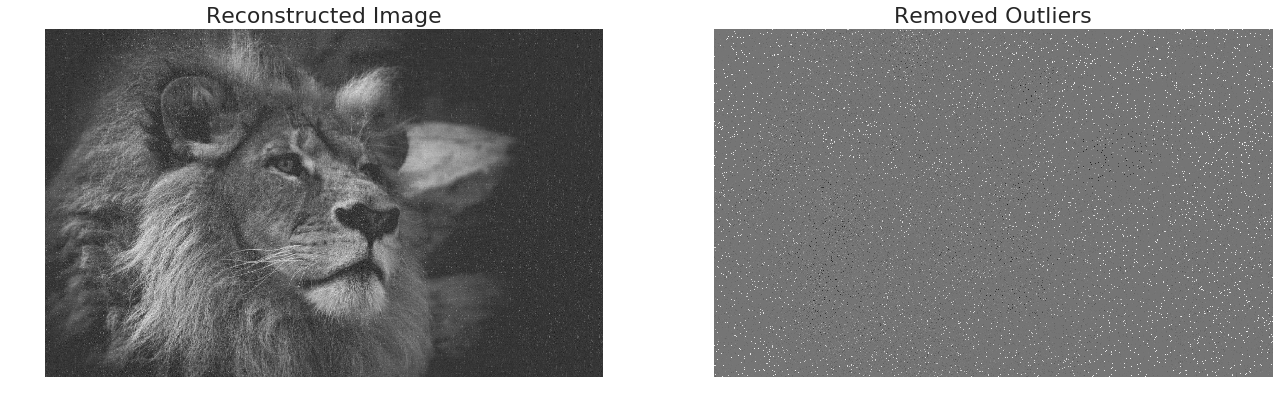

In [20]:
# Display image
f = plt.figure(figsize=(22,9))
f.add_subplot(121)
plt.imshow(Are, cmap = 'gray')
plt.axis('off')
plt.title('Reconstructed Image', fontsize=22)

f.add_subplot(122)
plt.imshow(E, cmap = 'gray')
plt.axis('off')
plt.title('Removed Outliers', fontsize=22)
plt.show()


# Scaling the SVD

Now, we use the SVD to extract features from high-resolution sea surface temperature (SST) data.  The SST data are widely studied in climate science for climate monitoring and prediction, providing an improved understanding
of the interactions between the ocean and the atmosphere. Specifically, the daily SST measurements are constructed by combining infrared satellite data with observations provided by ships and buoys.  In order to account and compensate for platform differences and sensor errors, a bias-adjusted methodology is used to combine the measurements from the different sources.  Finally, the spatially complete SST map is produced via interpolation. The data are provided by the National Oceanic and Atmospheric Administration (NOAA) via their web site at https://www.esrl.noaa.gov/psd/.  

Data are available for the years from 1981 to 2018 with a temporal resolution of 1 day and a spatial grid resolution of $0.25$ grad.  In total, the data consists of $m = 13,149$ temporal snapshots which measure the daily temperature
at $1440×720 = 1,036,800$ spatial grid points.  Since we omit data over land, the ambient dimension reduces to
$n= 691,150$ spatial measurements in our analysis. Concatenating the reduced data yield a 36GB data matrix of dimension $691,150×13,149$, which is sufficiently large to test scaling.

The data are stored in a hdf5 file and are to big to fit into our fast memory. However, the hdf5 data format allows us to efficentlys access parts of the data, i.e., we can read in some columns or some rows. We start by creating a new h5py object:

In [21]:
f = h5py.File("/home/ben/Dropbox/Talks/Open Data/data/sstHD.hdf5", "r")

Now, we can visualize a couple of th snapshots:

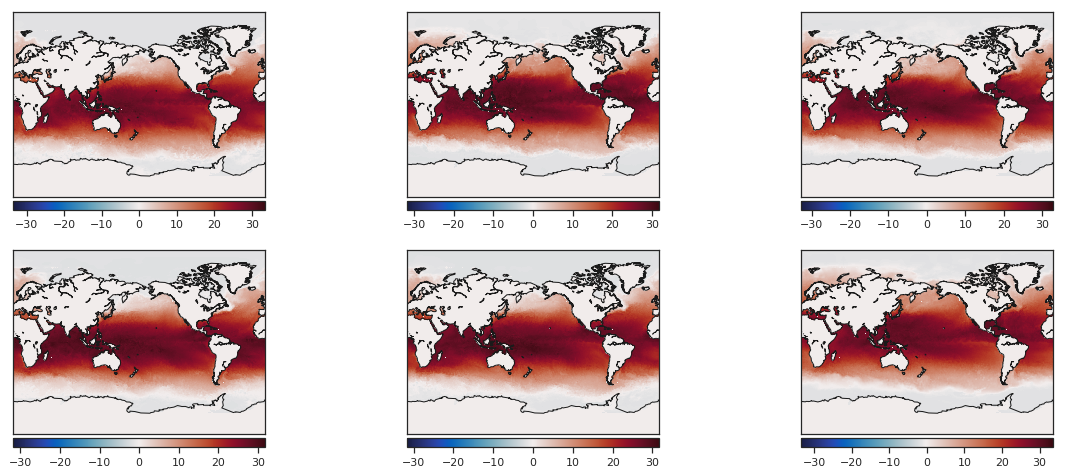

In [22]:
plot_frames(f['sstHD'][:,[0,1000,2000,3000,4000,5000]], x=2, y=3)

Trying to use the SVD provided by Numpy or Scipy will result into a memory error (you can try it yourself):

In [23]:
#U, s, Vt = tsvd(f['sstHD'], rank=10)

The randomized SVD function provided by the ristretto package allows us to compute the SVD using a blocked scheme. You can controll the number of blocks via the argument ```n_blocks```. This will take about 2 minutes, so that is a good point to grab a cup of coffee. 

In [24]:
%%time
U, s, Vt = rsvd(f['sstHD'], rank=200, n_blocks=5)

CPU times: user 9min 5s, sys: 33.4 s, total: 9min 39s
Wall time: 3min 18s


Now, we can plot the first six extracted modes (left singular vectors). 

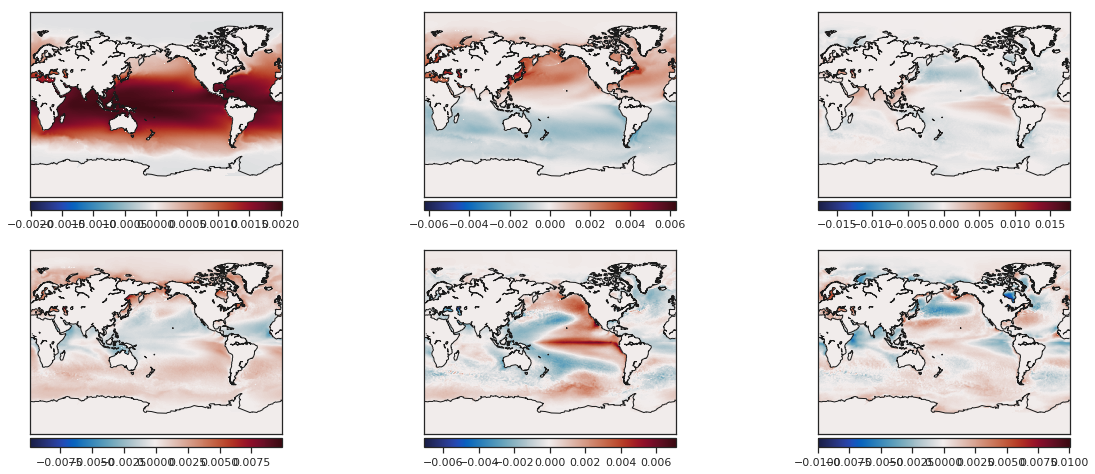

In [26]:
plot_frames(U, x=2, y=3)

The lower middle plot identifies the intermittent El Niño and La Niña warming events, which are famously implicated in global weather patterns and climate change. The El Niño Southern Oscillation (ENSO) is defined as any sustained temperature anomaly above running mean temperature with a duration of 9 to 24 months. The canonical El Niño is associated with a narrow band of warm water off coastal Peru that is commonly referred as NIÑO 1+2, 3, 3.4, or 4 to differentiate the types of bands. This mode is often used to compute the canonical Oceanic Niño Index (ONI).

# EMNIST Classification  using Randomized PCA and Random Forest

The Extended MNIST (EMNIST)is a dataset that poses a more challenging
classification tasks than MNIST. More concreatly, it involves  letters  and  digits. For more details have a look here:
* EMNIST: an extension of MNIST to handwritten letters: https://arxiv.org/pdf/1702.05373v1.pdf [1]
* NIST: https://www.nist.gov/itl/iad/image-group/emnist-dataset

Motivation for the following couple of line is the question if we can build a simple predictive model which is compareable with the the accuracy ($~78\%$) of the classification report in [1]. However, instead of using a NN with a large number of hidden layers, we use some old school techniques. So, how good can we do in 5 minutes? Lets get the dataset:

In [27]:
training_input, training_targets, testing_input, testing_targets, training_labels, testing_labels = load_emnist('/home/ben/Dropbox/Talks/Open Data/data/emnist-balanced.mat')

The dataset comprises 47 classes, 112800 instances for training and 18800 instances for testing. Each instance is a 28×28 pixel images, meaning that they are 784-dimensional if we consider each pixel as a variable. Here are some samples:

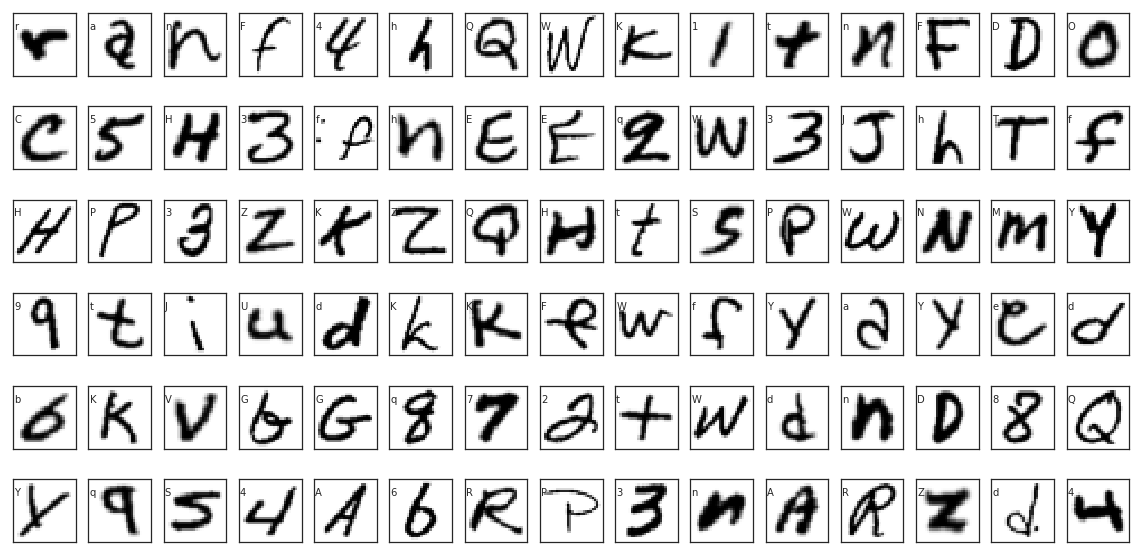

In [28]:
plot_emnist(training_input, training_labels, 6, 15)

To compute the principal components via the SVD we need to mean center the data:

In [29]:
Xtrain_mean = np.mean(training_input, axis=0)

training_centered = training_input - Xtrain_mean
testing_centered = testing_input - Xtrain_mean

Now, we can simply use the rsvd routine from the ristretto library to compute the top $60$ principal directions:

In [30]:
%%time
_, _, A = tsvd(training_centered, rank=60)  # project from 784 to 2 dimensions

CPU times: user 42.2 s, sys: 2.6 s, total: 44.8 s
Wall time: 7.87 s


Here are the extracted principal directions:

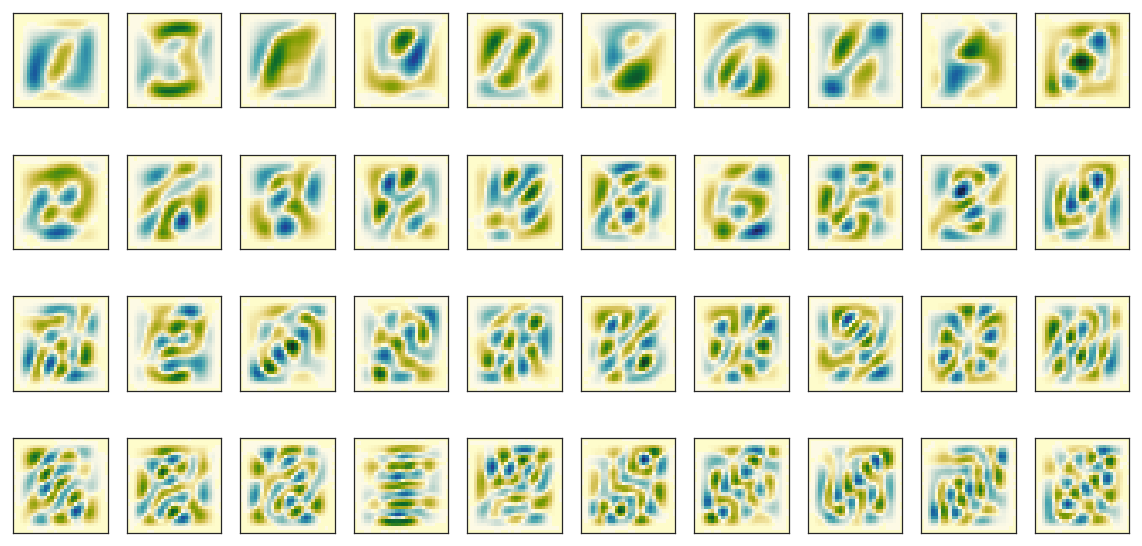

In [31]:
plot_components(A.T, 4, 10)

Then, we project the data to low-dimensional space, i.e., compute the new principal components which we will use as our new features for classification later:

In [32]:
Z_pca_training = training_centered.dot(A.T)
Z_pca_testing = testing_centered.dot(A.T)

If you like the sci-kit learn better, feel free to use the following couple of lines. Note, that the PCA function is using the randomized svd, too!

In [33]:
#%%time
#from sklearn.decomposition import PCA
#pca = PCA(n_components=50)
#pca.fit(training_centered)
#Z_pca_training = pca.transform(training_centered)
#Z_pca_testing = pca.transform(testing_centered)

Now, we are ready to use the random forest technique (https://en.wikipedia.org/wiki/Random_forest) for classification. Specifically, we use the algorithm implemented in the scikit-learn package (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with its default settings.

In [34]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
model_RF = RandomForestClassifier(n_estimators=50, random_state=123)
model_RF.fit(Z_pca_training, training_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

Here is classification summary:

In [36]:
ypred = model_RF.predict(Z_pca_testing)
print(metrics.classification_report(ypred, testing_targets, target_names=testing_labels))

             precision    recall  f1-score   support

          g       0.69      0.59      0.64       462
          e       0.61      0.52      0.56       466
          9       0.76      0.77      0.77       394
          Q       0.92      0.81      0.86       456
          q       0.78      0.71      0.74       438
          X       0.71      0.80      0.75       356
          E       0.87      0.83      0.85       419
          B       0.94      0.87      0.91       432
          3       0.72      0.74      0.73       393
          C       0.71      0.58      0.64       487
          G       0.80      0.74      0.77       429
          7       0.74      0.76      0.75       390
          2       0.91      0.85      0.88       425
          G       0.77      0.78      0.78       394
          G       0.84      0.86      0.85       391
          R       0.53      0.58      0.55       370
          6       0.76      0.80      0.78       383
          q       0.81      0.81      0.81   

Wow! We did good, didn't we? Well, can do better using another 5 minutes?

## Sparse Features for Learning

Now, we explore how good sparse features will do as input for or predictive model. We will use the sparse PCA function of the ristretto package to compute the sparse features. Don't worry if you haven't used sparse PCA before, the details do not matter so much for the moment. Again, we will compute $50$ sparse features, whereas we control the level of sparsity with the tuning parameter $\alpha$. 

In [37]:
from ristretto.pca import compute_rspca as rspca
B, _, _, _ = rspca(training_centered, n_components=60, alpha=1e-3, beta=1e-8, max_iter=1000)

We can visualize the computed sparse weights:

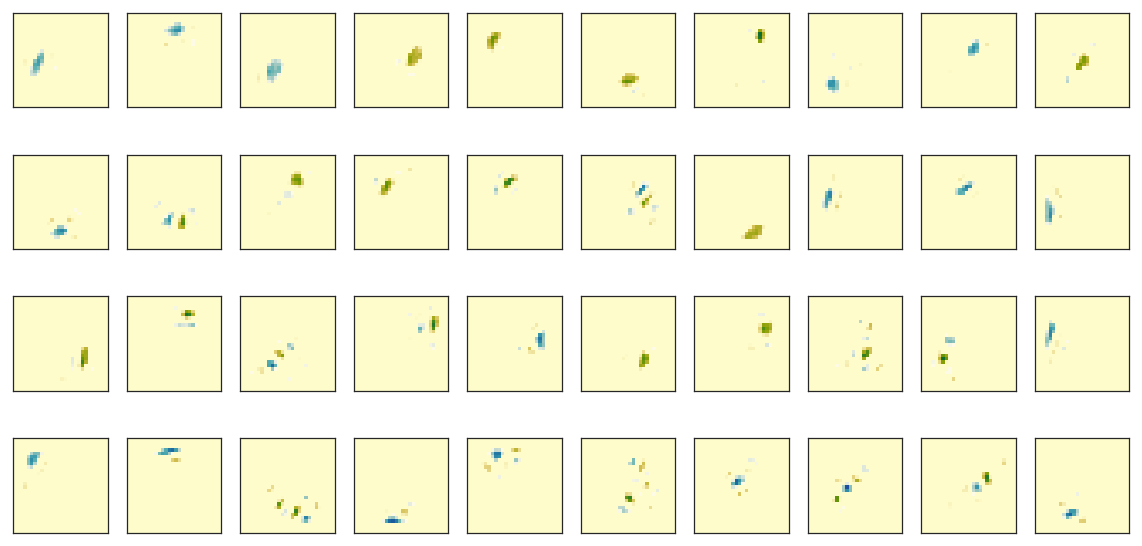

In [38]:
plot_components(B, 4, 10)

Again, we project the data to low-dimensional space, i.e., compute the new principal components which we will use as our new features for classification later. However, this time we use our new sparse weights:

In [39]:
Z_spca_training = training_centered.dot(B)
Z_spca_testing = testing_centered.dot(B)

Let us feed the new feature in our classification machine and see how good we do:

In [40]:
model_RF = RandomForestClassifier(n_estimators=50, random_state=123)
model_RF.fit(Z_spca_training, training_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [41]:
# predict classes
ypred_sparse = model_RF.predict(Z_spca_testing)
print(metrics.classification_report(ypred_sparse, testing_targets, target_names=testing_labels))

             precision    recall  f1-score   support

          g       0.70      0.60      0.65       468
          e       0.64      0.54      0.59       467
          9       0.79      0.83      0.81       379
          Q       0.91      0.89      0.90       407
          q       0.82      0.82      0.82       400
          X       0.74      0.83      0.78       355
          E       0.88      0.84      0.86       420
          B       0.94      0.90      0.92       418
          3       0.77      0.74      0.76       415
          C       0.78      0.60      0.67       521
          G       0.88      0.77      0.82       457
          7       0.83      0.77      0.80       430
          2       0.88      0.88      0.88       400
          G       0.80      0.78      0.79       414
          G       0.86      0.89      0.88       388
          R       0.56      0.65      0.60       347
          6       0.81      0.83      0.82       390
          q       0.86      0.89      0.87   

# Some more Insights about the Randomized SVD

The ristretto package advocates a two-stage probabilistic framework to compute a near-optimal low-rank approximation.  Conceptually, this framework splits the computation into the two logical steps:

* $\textbf{Stage A:}$ Construct a low dimensional subspace that approximates the range of $\mathbf{A} \in \mathbb{R}^{m\times n}$. Specifically, it is the aim to find a matrix $\mathbf{Q} \in \mathbb{R}^{m\times k}$ with orthonormal columns, where $k$ denotes the target rank, such that $\mathbf{A} \approx \mathbf{Q}\mathbf{Q}^\intercal\mathbf{A}$ is satisfied. 

* $\textbf{Stage B:}$ Form a smaller matrix $\mathbf{B} \in \mathbb{R}^{k\times n}$ by restricting the high-dimensional input matrix to the low-dimensional space spanned by the near-optimal basis $\mathbf{Q}$. This smaller matrix can then be used to compute a desired low-rank approximation.

The first computational stage is where randomness comes into the play, while the second stage
is purely deterministic.  In the following, the two stages are described in more detail. Pictorially, here is what we do:


<img src="img/stageA.png" alt="Drawing" style="width: 600px;"/>



### Stage A
***********

Okay, now the first step is to generate a random test matrix $\mathbf{\Omega}$ of dimension $n \times l$ were $l=k+p$. Here, we need to define a target rank $k$, i.e, we need to decide how many dominant singular vectors and values we aim to approximate. Further, to improve the approximation accuracy, we introduce some slight oversampling in addition, here we use $p=20$. We will use the image, which we used at the very beginning, as an example again.

In [42]:
A = plt.imread('./data/lion.jpg') # Read image
A = np.dot(A[...,:3], [0.299, 0.587, 0.114]) # Convert to a grayscale image
m, n = A.shape # Get shape

We start with drawing the entries of $\mathbf{\Omega}$ from the standard normal distribution:

In [43]:
k, p = 200, 20

In [44]:
Omega = sci.random.standard_normal((n, (k+p))) # standard normal distribution

Next, we compute the samples matrix $\mathbf{Y}$, i.e., we sketch the column space of the input matrix (image) $\mathbf{A}$.

In [45]:
Y = A.dot(Omega)

To improve the accuracy of the basis, we can perform additional power iterations. We leave this as an exercise, but skip this for the moment. If you need some guidance, have a look to https://arxiv.org/pdf/1608.02148.pdf on page 9 to Algorithm 2. 

In [46]:
q = 2 # number of (optional) power iterations

#for i in range(q):
    # compute QR decomposition of Y
    # compute QR decomposition of A.T.dot(Q) 
    # update samples matrix Y as Y = A.dot(Q)

$\mathbf{Y}$ forms a basis for the column space of the input matrix, we can use the 'economic' QR decomposition to form a orthonormal basis, so that $\mathbf{Q}^\top\mathbf{Q}=\mathbf{I}$. 

In [47]:
Q , _ = sci.linalg.qr(Y ,  mode='economic' ) 

### Stage B
************
Now, having $\mathbf{Q}$, we aim to find a smaller matrix $\mathbf{B} \in \mathbb{R}^{l \times n}$. Therefor, we simply project the high-dimensional input matrix $\mathbf{A}$ to the low-dimensional space as 
\begin{equation}
\mathbf{B} = \mathbf{Q}^\top\mathbf{A}.
\end{equation}


In [48]:
B = Q.T.dot(A)

The approximate SVD is computed using a standard (deterministic) algorithm so that we attain the following decomposition
\begin{equation} 
\mathbf{B} = \mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V}^\top.	
\end{equation} 


In [49]:
Utilde, s , Vt = np.linalg.svd( B , full_matrices=False)

It remains to recover the high-dimensional left singular vectors. Recall that
	$\mathbf{A} \approx  \mathbf{Q}{\mathbf{Q^{\top}}\mathbf{A}} = \mathbf{Q} {\mathbf{B}} = \mathbf{Q}\mathbf{\tilde{U}} \mathbf{\Sigma}\mathbf{V^{\top}}= \mathbf{U} \mathbf{\Sigma}\mathbf{V^{\top}}$. Hence, $\mathbf{\tilde{U}}:= \mathbf{Q}\mathbf{\tilde{U}}$.	

In [50]:
U = Q.dot(Utilde)

Let's see how good the approximation is.

In [51]:
A_rsvd = (U*s).dot(Vt)

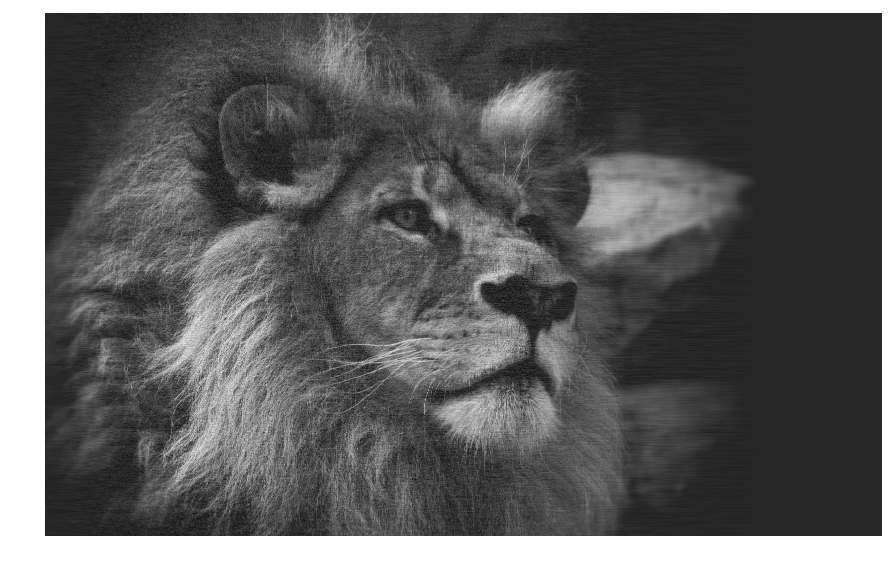

In [52]:
# Display image
fig = plt.figure(figsize=(15, 11))
plt.imshow(A_rsvd, cmap = 'gray')
plt.axis('off')
plt.show()

We can compute the relative reconstruction error to quantify the performance of the randomized algorithm.

In [53]:
#Print relative error
print('Relative error:', sci.linalg.norm(A-A_rsvd)/sci.linalg.norm(A))

Relative error: 0.16493690252


Now, try it with two additional power iterations / subspace iterations and see if you can improve the error.